In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

## SD 1.5

In [10]:
%load_ext autoreload
%autoreload 2


import sys
sys.path.append('../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from diffusers import StableDiffusionPipeline
import torch
import pandas as pd
from diffusers.utils import load_image
from tqdm import tqdm
from diffusers import StableDiffusionPipeline

In [3]:
model_id = "runwayml/stable-diffusion-v1-5"                                                                                                                                                                                                                
pipe = StableDiffusionPipeline.from_pretrained(model_id).to("cuda")
pipe.safety_checker = None
generator = torch.Generator("cuda").manual_seed(0)
pipe.load_ip_adapter("h94/IP-Adapter", subfolder="models", weight_name="ip-adapter_sd15.bin")      

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

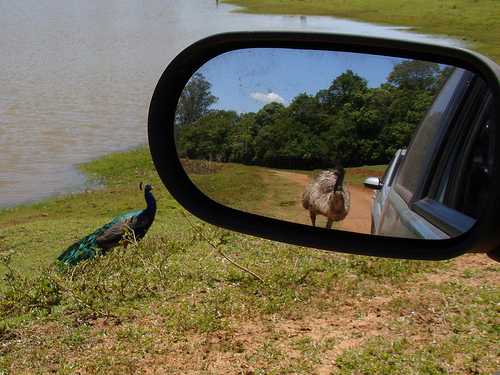

In [4]:
ratings_df = pd.read_csv("../data/flickr/processed/ratings.csv")
path = "../data/flickr/raw/FLICKR-AES-001/40K/" + ratings_df.imagePair.unique()[2]
load_image(path)

In [5]:
from PIL import Image
from pathlib import Path
import math
# ---------- helper ----------
def load_image(path: str | Path) -> Image.Image:
    return Image.open(path).convert("RGB").resize((512, 512))

In [9]:
type(img)

PIL.Image.Image

In [15]:
img = load_image(path)
device = "cuda"

# grab the *hidden state* (1024-d) –  output_hidden_states=True triggers branch A
emb_hidden, _ = pipe.encode_image(
    img, device=device, num_images_per_prompt=1
)  # tensor shape (1, 1024)

d = emb_hidden.shape[-1]                      # 1024
emb_unit   = emb_hidden / emb_hidden.norm(dim=-1, keepdim=True)     # ‖x‖₂ = 1

pos = emb_unit.unsqueeze(0).unsqueeze(0)  # (1,1,D)
neg = torch.zeros_like(pos)
ip  = torch.cat([neg, pos], dim=0) 

In [16]:
emb_hidden.norm(dim=-1, keepdim=True)

tensor([[20.5357]], device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

In [17]:
emb_hidden.norm(dim=-1, keepdim=True).shape

torch.Size([1, 1])

  0%|          | 0/100 [00:00<?, ?it/s]

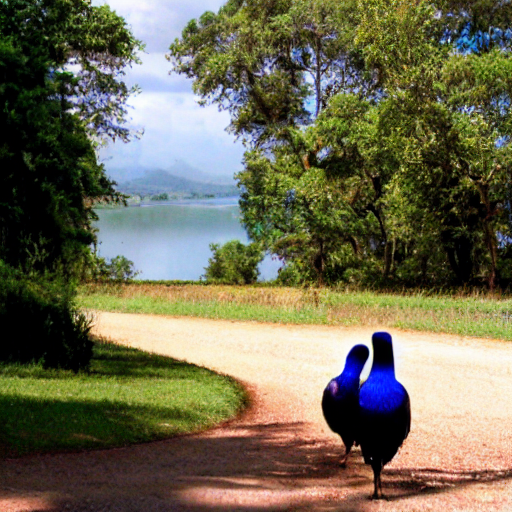

In [20]:
generator = torch.Generator("cuda").manual_seed(0)
pipe.set_ip_adapter_scale(1.0)
result = pipe(
    prompt="",                               # empty text prompt
    negative_prompt="",                      # no negative either
    ip_adapter_image_embeds=[ip],     # list-of-tensors API
    num_inference_steps=100,
                     # ignore the (empty) text ctx
    generator=generator,
).images

result[0]

  0%|          | 0/100 [00:00<?, ?it/s]

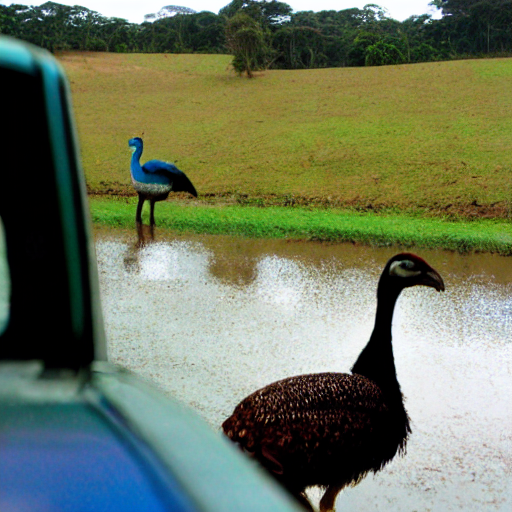

In [21]:
generator = torch.Generator("cuda").manual_seed(0)
prompt=""

pos = pipe.encode_image(load_image(path), device="cuda", num_images_per_prompt=1)[0].unsqueeze(0).unsqueeze(0)  # (1,1,D)
neg = torch.zeros_like(pos)
ip  = torch.cat([neg, pos], dim=0) 
image = pipe(
    prompt=prompt,
    ip_adapter_image_embeds=[ip],
    negative_prompt="",
    num_inference_steps=100,
    generator=generator,
).images
image[0]

### Addressing distribution shift from ground-truth images

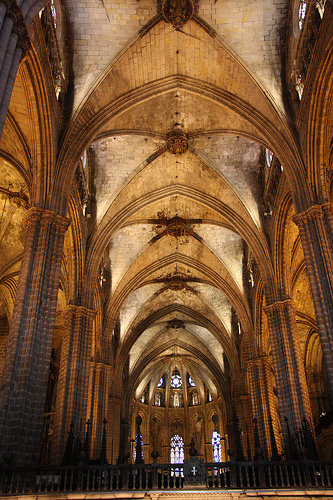

In [ ]:
import os

test_df = pd.read_csv("../data/flickr/processed/test_usrthrs_100.csv")
path = "../data/flickr/raw/40K/" + test_df.imagePair.unique()[2]
load_image(path)


In [16]:
test_df = pd.read_csv("../data/flickr/processed/test_usrthrs_100.csv")

seed = 42  # or any fixed integer
generator = torch.Generator(device="cuda").manual_seed(seed)

# Output directory
output_dir = "../data/flickr/processed/distshiftless/T0"
os.makedirs(output_dir, exist_ok=True)

# Process images
for image_pair in tqdm(test_df.imagePair.unique(), desc="Processing images"):
    path = f"../data/flickr/raw/40K/{image_pair}"

    # Load and encode image
    image_embed = pipe.encode_image(load_image(path), device="cuda", num_images_per_prompt=1)[0].unsqueeze(0)

    # Run pipeline
    generated_image = pipe(
        prompt="",
        ip_adapter_image_embeds=[image_embed],
        negative_prompt="",
        num_inference_steps=100,
        generator=generator,
    ).images[0]

    # Save generated image
    output_path = os.path.join(output_dir, os.path.basename(image_pair))
    generated_image.save(output_path)

Processing images:   0%|          | 0/929 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   0%|          | 1/929 [00:13<3:28:47, 13.50s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   0%|          | 2/929 [00:26<3:25:00, 13.27s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   0%|          | 3/929 [00:39<3:22:54, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   0%|          | 4/929 [00:52<3:22:00, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   1%|          | 5/929 [01:05<3:21:32, 13.09s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   1%|          | 6/929 [01:19<3:23:03, 13.20s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   1%|          | 7/929 [01:32<3:24:23, 13.30s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   1%|          | 8/929 [01:46<3:24:46, 13.34s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   1%|          | 9/929 [01:59<3:25:38, 13.41s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   1%|          | 10/929 [02:13<3:26:04, 13.45s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   1%|          | 11/929 [02:26<3:26:15, 13.48s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   1%|▏         | 12/929 [02:40<3:25:55, 13.47s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   1%|▏         | 13/929 [02:53<3:25:32, 13.46s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   2%|▏         | 14/929 [03:07<3:26:13, 13.52s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   2%|▏         | 15/929 [03:20<3:26:53, 13.58s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   2%|▏         | 16/929 [03:34<3:26:45, 13.59s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   2%|▏         | 17/929 [03:47<3:25:11, 13.50s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   2%|▏         | 18/929 [04:01<3:25:33, 13.54s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   2%|▏         | 19/929 [04:15<3:26:53, 13.64s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   2%|▏         | 20/929 [04:29<3:27:14, 13.68s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   2%|▏         | 21/929 [04:43<3:28:43, 13.79s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   2%|▏         | 22/929 [04:57<3:28:35, 13.80s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   2%|▏         | 23/929 [05:10<3:28:27, 13.81s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   3%|▎         | 24/929 [05:24<3:28:42, 13.84s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   3%|▎         | 25/929 [05:38<3:28:19, 13.83s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   3%|▎         | 26/929 [05:52<3:27:51, 13.81s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   3%|▎         | 27/929 [06:06<3:28:22, 13.86s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   3%|▎         | 28/929 [06:20<3:28:17, 13.87s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   3%|▎         | 29/929 [06:33<3:26:06, 13.74s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   3%|▎         | 30/929 [06:47<3:26:13, 13.76s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   3%|▎         | 31/929 [07:00<3:24:54, 13.69s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   3%|▎         | 32/929 [07:14<3:24:49, 13.70s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   4%|▎         | 33/929 [07:28<3:24:52, 13.72s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   4%|▎         | 34/929 [07:42<3:23:47, 13.66s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   4%|▍         | 35/929 [07:56<3:25:13, 13.77s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   4%|▍         | 36/929 [08:09<3:22:58, 13.64s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   4%|▍         | 37/929 [08:22<3:22:25, 13.62s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   4%|▍         | 38/929 [08:36<3:21:39, 13.58s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   4%|▍         | 39/929 [08:49<3:20:53, 13.54s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   4%|▍         | 40/929 [09:03<3:20:36, 13.54s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   4%|▍         | 41/929 [09:17<3:20:51, 13.57s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   5%|▍         | 42/929 [09:30<3:21:04, 13.60s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   5%|▍         | 43/929 [09:44<3:21:54, 13.67s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   5%|▍         | 44/929 [09:58<3:21:47, 13.68s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   5%|▍         | 45/929 [10:11<3:21:40, 13.69s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   5%|▍         | 46/929 [10:25<3:22:18, 13.75s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   5%|▌         | 47/929 [10:39<3:22:42, 13.79s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   5%|▌         | 48/929 [10:53<3:22:09, 13.77s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   5%|▌         | 49/929 [11:07<3:22:11, 13.79s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   5%|▌         | 50/929 [11:20<3:21:28, 13.75s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   5%|▌         | 51/929 [11:34<3:22:00, 13.80s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   6%|▌         | 52/929 [11:48<3:20:52, 13.74s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   6%|▌         | 53/929 [12:02<3:20:06, 13.71s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   6%|▌         | 54/929 [12:15<3:18:47, 13.63s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   6%|▌         | 55/929 [12:29<3:17:47, 13.58s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   6%|▌         | 56/929 [12:42<3:17:05, 13.55s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   6%|▌         | 57/929 [12:55<3:16:35, 13.53s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   6%|▌         | 58/929 [13:09<3:16:11, 13.51s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   6%|▋         | 59/929 [13:22<3:16:00, 13.52s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   6%|▋         | 60/929 [13:36<3:16:01, 13.53s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   7%|▋         | 61/929 [13:50<3:15:38, 13.52s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   7%|▋         | 62/929 [14:03<3:14:56, 13.49s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   7%|▋         | 63/929 [14:16<3:14:48, 13.50s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   7%|▋         | 64/929 [14:30<3:14:14, 13.47s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   7%|▋         | 65/929 [14:43<3:13:50, 13.46s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   7%|▋         | 66/929 [14:57<3:14:25, 13.52s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   7%|▋         | 67/929 [15:11<3:14:12, 13.52s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   7%|▋         | 68/929 [15:24<3:14:28, 13.55s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   7%|▋         | 69/929 [15:38<3:14:28, 13.57s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   8%|▊         | 70/929 [15:51<3:13:37, 13.52s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   8%|▊         | 71/929 [16:05<3:13:16, 13.52s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   8%|▊         | 72/929 [16:18<3:12:55, 13.51s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   8%|▊         | 73/929 [16:32<3:12:27, 13.49s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   8%|▊         | 74/929 [16:45<3:12:28, 13.51s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   8%|▊         | 75/929 [16:59<3:12:09, 13.50s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   8%|▊         | 76/929 [17:12<3:11:53, 13.50s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   8%|▊         | 77/929 [17:26<3:11:16, 13.47s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   8%|▊         | 78/929 [17:39<3:11:02, 13.47s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   9%|▊         | 79/929 [17:53<3:11:07, 13.49s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   9%|▊         | 80/929 [18:06<3:10:37, 13.47s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   9%|▊         | 81/929 [18:20<3:10:50, 13.50s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   9%|▉         | 82/929 [18:33<3:10:10, 13.47s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   9%|▉         | 83/929 [18:46<3:09:59, 13.47s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   9%|▉         | 84/929 [19:00<3:09:44, 13.47s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   9%|▉         | 85/929 [19:13<3:09:27, 13.47s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   9%|▉         | 86/929 [19:27<3:09:46, 13.51s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   9%|▉         | 87/929 [19:40<3:08:02, 13.40s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:   9%|▉         | 88/929 [19:53<3:06:28, 13.30s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
Processing images:  10%|▉         | 89/929 [20:06<3:05:21, 13.24s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  10%|▉         | 90/929 [20:19<3:04:43, 13.21s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  10%|▉         | 91/929 [20:33<3:04:33, 13.21s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  10%|▉         | 92/929 [20:46<3:05:04, 13.27s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  10%|█         | 93/929 [21:00<3:05:56, 13.35s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  10%|█         | 94/929 [21:13<3:06:00, 13.37s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  10%|█         | 95/929 [21:26<3:04:54, 13.30s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  10%|█         | 96/929 [21:40<3:05:07, 13.33s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
Processing images:  10%|█         | 97/929 [21:53<3:04:21, 13.29s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  11%|█         | 98/929 [22:06<3:03:35, 13.26s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  11%|█         | 99/929 [22:19<3:03:31, 13.27s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  11%|█         | 100/929 [22:33<3:03:41, 13.29s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  11%|█         | 101/929 [22:46<3:03:54, 13.33s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  11%|█         | 102/929 [23:00<3:04:44, 13.40s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  11%|█         | 103/929 [23:13<3:03:39, 13.34s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  11%|█         | 104/929 [23:26<3:02:50, 13.30s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  11%|█▏        | 105/929 [23:39<3:02:12, 13.27s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  11%|█▏        | 106/929 [23:52<3:01:41, 13.25s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  12%|█▏        | 107/929 [24:06<3:01:22, 13.24s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  12%|█▏        | 108/929 [24:19<3:02:18, 13.32s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  12%|█▏        | 109/929 [24:33<3:02:41, 13.37s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  12%|█▏        | 110/929 [24:46<3:02:12, 13.35s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  12%|█▏        | 111/929 [24:59<3:01:19, 13.30s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  12%|█▏        | 112/929 [25:12<3:00:23, 13.25s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  12%|█▏        | 113/929 [25:25<2:59:28, 13.20s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  12%|█▏        | 114/929 [25:38<2:58:51, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  12%|█▏        | 115/929 [25:51<2:58:18, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  12%|█▏        | 116/929 [26:05<2:58:00, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  13%|█▎        | 117/929 [26:18<2:57:35, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  13%|█▎        | 118/929 [26:31<2:57:28, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  13%|█▎        | 119/929 [26:44<2:58:09, 13.20s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  13%|█▎        | 120/929 [26:57<2:57:39, 13.18s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  13%|█▎        | 121/929 [27:10<2:57:10, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  13%|█▎        | 122/929 [27:23<2:56:45, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  13%|█▎        | 123/929 [27:37<2:56:24, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  13%|█▎        | 124/929 [27:50<2:56:02, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  13%|█▎        | 125/929 [28:03<2:55:41, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  14%|█▎        | 126/929 [28:16<2:55:30, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  14%|█▎        | 127/929 [28:29<2:55:43, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  14%|█▍        | 128/929 [28:42<2:55:34, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  14%|█▍        | 129/929 [28:55<2:55:16, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  14%|█▍        | 130/929 [29:09<2:55:06, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  14%|█▍        | 131/929 [29:22<2:54:43, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  14%|█▍        | 132/929 [29:35<2:54:31, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  14%|█▍        | 133/929 [29:48<2:54:10, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  14%|█▍        | 134/929 [30:01<2:53:48, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  15%|█▍        | 135/929 [30:14<2:53:29, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  15%|█▍        | 136/929 [30:27<2:53:44, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  15%|█▍        | 137/929 [30:41<2:53:55, 13.18s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  15%|█▍        | 138/929 [30:54<2:53:36, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  15%|█▍        | 139/929 [31:07<2:53:07, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  15%|█▌        | 140/929 [31:20<2:52:40, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  15%|█▌        | 141/929 [31:33<2:52:24, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  15%|█▌        | 142/929 [31:46<2:52:04, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  15%|█▌        | 143/929 [31:59<2:51:52, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  16%|█▌        | 144/929 [32:12<2:51:29, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  16%|█▌        | 145/929 [32:25<2:51:21, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  16%|█▌        | 146/929 [32:39<2:51:07, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  16%|█▌        | 147/929 [32:52<2:51:12, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  16%|█▌        | 148/929 [33:05<2:50:58, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  16%|█▌        | 149/929 [33:18<2:50:38, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  16%|█▌        | 150/929 [33:31<2:50:17, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  16%|█▋        | 151/929 [33:44<2:50:06, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  16%|█▋        | 152/929 [33:57<2:49:55, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  16%|█▋        | 153/929 [34:10<2:49:42, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  17%|█▋        | 154/929 [34:24<2:49:40, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  17%|█▋        | 155/929 [34:37<2:49:24, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  17%|█▋        | 156/929 [34:50<2:49:30, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  17%|█▋        | 157/929 [35:03<2:49:08, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  17%|█▋        | 158/929 [35:16<2:48:39, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  17%|█▋        | 159/929 [35:29<2:48:19, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  17%|█▋        | 160/929 [35:42<2:48:02, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  17%|█▋        | 161/929 [35:55<2:47:40, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  17%|█▋        | 162/929 [36:09<2:47:23, 13.09s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  18%|█▊        | 163/929 [36:22<2:47:20, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  18%|█▊        | 164/929 [36:35<2:47:23, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  18%|█▊        | 165/929 [36:48<2:47:32, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  18%|█▊        | 166/929 [37:01<2:46:58, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  18%|█▊        | 167/929 [37:14<2:46:33, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  18%|█▊        | 168/929 [37:27<2:46:15, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  18%|█▊        | 169/929 [37:40<2:45:50, 13.09s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  18%|█▊        | 170/929 [37:53<2:45:40, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  18%|█▊        | 171/929 [38:07<2:45:26, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  19%|█▊        | 172/929 [38:20<2:45:11, 13.09s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  19%|█▊        | 173/929 [38:33<2:44:58, 13.09s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  19%|█▊        | 174/929 [38:46<2:44:46, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  19%|█▉        | 175/929 [38:59<2:44:41, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  19%|█▉        | 176/929 [39:12<2:44:23, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  19%|█▉        | 177/929 [39:25<2:44:14, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  19%|█▉        | 178/929 [39:38<2:44:02, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  19%|█▉        | 179/929 [39:51<2:43:52, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  19%|█▉        | 180/929 [40:04<2:43:32, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
Processing images:  19%|█▉        | 181/929 [40:18<2:43:19, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  20%|█▉        | 182/929 [40:31<2:43:23, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  20%|█▉        | 183/929 [40:44<2:43:26, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  20%|█▉        | 184/929 [40:57<2:43:13, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  20%|█▉        | 185/929 [41:10<2:42:53, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  20%|██        | 186/929 [41:23<2:42:35, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  20%|██        | 187/929 [41:36<2:42:10, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  20%|██        | 188/929 [41:50<2:41:58, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  20%|██        | 189/929 [42:03<2:41:40, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  20%|██        | 190/929 [42:16<2:41:27, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  21%|██        | 191/929 [42:29<2:41:27, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  21%|██        | 192/929 [42:42<2:41:33, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  21%|██        | 193/929 [42:55<2:41:14, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  21%|██        | 194/929 [43:08<2:40:56, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  21%|██        | 195/929 [43:21<2:40:34, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  21%|██        | 196/929 [43:35<2:40:15, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  21%|██        | 197/929 [43:48<2:39:56, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  21%|██▏       | 198/929 [44:01<2:39:44, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  21%|██▏       | 199/929 [44:14<2:39:32, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  22%|██▏       | 200/929 [44:27<2:39:13, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  22%|██▏       | 201/929 [44:40<2:39:01, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  22%|██▏       | 202/929 [44:53<2:38:51, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  22%|██▏       | 203/929 [45:06<2:38:44, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  22%|██▏       | 204/929 [45:19<2:38:29, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  22%|██▏       | 205/929 [45:33<2:38:10, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  22%|██▏       | 206/929 [45:46<2:37:55, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  22%|██▏       | 207/929 [45:59<2:37:42, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  22%|██▏       | 208/929 [46:12<2:37:31, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  22%|██▏       | 209/929 [46:25<2:37:42, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  23%|██▎       | 210/929 [46:38<2:37:50, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  23%|██▎       | 211/929 [46:52<2:37:53, 13.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  23%|██▎       | 212/929 [47:05<2:37:22, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  23%|██▎       | 213/929 [47:18<2:37:01, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  23%|██▎       | 214/929 [47:31<2:36:37, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  23%|██▎       | 215/929 [47:44<2:36:19, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  23%|██▎       | 216/929 [47:57<2:36:02, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  23%|██▎       | 217/929 [48:10<2:35:54, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  23%|██▎       | 218/929 [48:23<2:35:42, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  24%|██▎       | 219/929 [48:37<2:35:52, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  24%|██▎       | 220/929 [48:50<2:35:40, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  24%|██▍       | 221/929 [49:03<2:35:16, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  24%|██▍       | 222/929 [49:16<2:34:50, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  24%|██▍       | 223/929 [49:29<2:34:26, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  24%|██▍       | 224/929 [49:42<2:34:00, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  24%|██▍       | 225/929 [49:55<2:33:47, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  24%|██▍       | 226/929 [50:08<2:33:37, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  24%|██▍       | 227/929 [50:22<2:33:20, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  25%|██▍       | 228/929 [50:35<2:32:59, 13.09s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  25%|██▍       | 229/929 [50:48<2:32:59, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  25%|██▍       | 230/929 [51:01<2:32:40, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  25%|██▍       | 231/929 [51:14<2:32:23, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  25%|██▍       | 232/929 [51:27<2:32:04, 13.09s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  25%|██▌       | 233/929 [51:40<2:31:53, 13.09s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  25%|██▌       | 234/929 [51:53<2:31:42, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  25%|██▌       | 235/929 [52:06<2:31:30, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  25%|██▌       | 236/929 [52:19<2:31:10, 13.09s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  26%|██▌       | 237/929 [52:33<2:31:24, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  26%|██▌       | 238/929 [52:46<2:31:33, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  26%|██▌       | 239/929 [52:59<2:31:12, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  26%|██▌       | 240/929 [53:12<2:30:48, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  26%|██▌       | 241/929 [53:25<2:30:27, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  26%|██▌       | 242/929 [53:38<2:30:06, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  26%|██▌       | 243/929 [53:51<2:30:01, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  26%|██▋       | 244/929 [54:05<2:29:44, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  26%|██▋       | 245/929 [54:18<2:29:38, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  26%|██▋       | 246/929 [54:31<2:29:36, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  27%|██▋       | 247/929 [54:44<2:29:37, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  27%|██▋       | 248/929 [54:57<2:29:16, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  27%|██▋       | 249/929 [55:10<2:28:51, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  27%|██▋       | 250/929 [55:23<2:28:29, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  27%|██▋       | 251/929 [55:36<2:28:14, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  27%|██▋       | 252/929 [55:50<2:27:59, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  27%|██▋       | 253/929 [56:03<2:27:41, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  27%|██▋       | 254/929 [56:16<2:27:24, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  27%|██▋       | 255/929 [56:29<2:27:25, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  28%|██▊       | 256/929 [56:42<2:27:20, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  28%|██▊       | 257/929 [56:55<2:27:04, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  28%|██▊       | 258/929 [57:08<2:26:44, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  28%|██▊       | 259/929 [57:21<2:26:26, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  28%|██▊       | 260/929 [57:35<2:26:12, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  28%|██▊       | 261/929 [57:48<2:26:01, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  28%|██▊       | 262/929 [58:01<2:25:44, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  28%|██▊       | 263/929 [58:14<2:25:36, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  28%|██▊       | 264/929 [58:27<2:25:48, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  29%|██▊       | 265/929 [58:40<2:26:04, 13.20s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  29%|██▊       | 266/929 [58:54<2:25:44, 13.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  29%|██▊       | 267/929 [59:07<2:25:13, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  29%|██▉       | 268/929 [59:20<2:24:47, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  29%|██▉       | 269/929 [59:33<2:24:26, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  29%|██▉       | 270/929 [59:46<2:24:07, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
Processing images:  29%|██▉       | 271/929 [59:59<2:23:55, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  29%|██▉       | 272/929 [1:00:12<2:23:44, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  29%|██▉       | 273/929 [1:00:25<2:23:39, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  29%|██▉       | 274/929 [1:00:39<2:23:38, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  30%|██▉       | 275/929 [1:00:52<2:23:24, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  30%|██▉       | 276/929 [1:01:05<2:23:01, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  30%|██▉       | 277/929 [1:01:18<2:22:37, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  30%|██▉       | 278/929 [1:01:31<2:22:18, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  30%|███       | 279/929 [1:01:44<2:22:05, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  30%|███       | 280/929 [1:01:57<2:21:55, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  30%|███       | 281/929 [1:02:10<2:21:38, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  30%|███       | 282/929 [1:02:24<2:21:34, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
Processing images:  30%|███       | 283/929 [1:02:37<2:21:16, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  31%|███       | 284/929 [1:02:50<2:21:04, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  31%|███       | 285/929 [1:03:03<2:20:48, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  31%|███       | 286/929 [1:03:16<2:20:35, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  31%|███       | 287/929 [1:03:29<2:20:20, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  31%|███       | 288/929 [1:03:42<2:20:06, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  31%|███       | 289/929 [1:03:55<2:19:54, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  31%|███       | 290/929 [1:04:09<2:19:41, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  31%|███▏      | 291/929 [1:04:22<2:19:38, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  31%|███▏      | 292/929 [1:04:35<2:19:39, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  32%|███▏      | 293/929 [1:04:48<2:19:48, 13.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  32%|███▏      | 294/929 [1:05:01<2:19:19, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  32%|███▏      | 295/929 [1:05:14<2:18:58, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  32%|███▏      | 296/929 [1:05:28<2:18:39, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  32%|███▏      | 297/929 [1:05:41<2:18:20, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  32%|███▏      | 298/929 [1:05:54<2:18:03, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  32%|███▏      | 299/929 [1:06:07<2:17:45, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  32%|███▏      | 300/929 [1:06:20<2:17:36, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  32%|███▏      | 301/929 [1:06:33<2:17:29, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  33%|███▎      | 302/929 [1:06:46<2:17:40, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  33%|███▎      | 303/929 [1:07:00<2:17:15, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  33%|███▎      | 304/929 [1:07:13<2:16:56, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  33%|███▎      | 305/929 [1:07:26<2:16:35, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  33%|███▎      | 306/929 [1:07:39<2:16:17, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  33%|███▎      | 307/929 [1:07:52<2:15:56, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  33%|███▎      | 308/929 [1:08:05<2:15:41, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  33%|███▎      | 309/929 [1:08:18<2:15:29, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  33%|███▎      | 310/929 [1:08:31<2:15:25, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  33%|███▎      | 311/929 [1:08:44<2:15:15, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  34%|███▎      | 312/929 [1:08:58<2:14:57, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  34%|███▎      | 313/929 [1:09:11<2:14:43, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  34%|███▍      | 314/929 [1:09:24<2:14:27, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  34%|███▍      | 315/929 [1:09:37<2:14:13, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  34%|███▍      | 316/929 [1:09:50<2:13:59, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  34%|███▍      | 317/929 [1:10:03<2:13:44, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  34%|███▍      | 318/929 [1:10:16<2:13:32, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  34%|███▍      | 319/929 [1:10:29<2:13:39, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  34%|███▍      | 320/929 [1:10:43<2:13:41, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  35%|███▍      | 321/929 [1:10:56<2:13:25, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  35%|███▍      | 322/929 [1:11:09<2:12:58, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  35%|███▍      | 323/929 [1:11:22<2:12:36, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  35%|███▍      | 324/929 [1:11:35<2:12:21, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  35%|███▍      | 325/929 [1:11:48<2:12:09, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  35%|███▌      | 326/929 [1:12:01<2:11:52, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  35%|███▌      | 327/929 [1:12:14<2:11:34, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  35%|███▌      | 328/929 [1:12:28<2:11:30, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  35%|███▌      | 329/929 [1:12:41<2:11:22, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  36%|███▌      | 330/929 [1:12:54<2:11:10, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  36%|███▌      | 331/929 [1:13:07<2:10:47, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  36%|███▌      | 332/929 [1:13:20<2:10:30, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  36%|███▌      | 333/929 [1:13:33<2:10:16, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  36%|███▌      | 334/929 [1:13:46<2:10:02, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  36%|███▌      | 335/929 [1:13:59<2:09:49, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  36%|███▌      | 336/929 [1:14:13<2:09:38, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  36%|███▋      | 337/929 [1:14:26<2:09:22, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  36%|███▋      | 338/929 [1:14:39<2:09:08, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  36%|███▋      | 339/929 [1:14:52<2:08:56, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  37%|███▋      | 340/929 [1:15:05<2:08:38, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  37%|███▋      | 341/929 [1:15:18<2:08:18, 13.09s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  37%|███▋      | 342/929 [1:15:31<2:08:06, 13.09s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  37%|███▋      | 343/929 [1:15:44<2:07:54, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  37%|███▋      | 344/929 [1:15:57<2:07:46, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  37%|███▋      | 345/929 [1:16:11<2:07:36, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  37%|███▋      | 346/929 [1:16:24<2:07:40, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  37%|███▋      | 347/929 [1:16:37<2:07:42, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  37%|███▋      | 348/929 [1:16:50<2:07:42, 13.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  38%|███▊      | 349/929 [1:17:03<2:07:15, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  38%|███▊      | 350/929 [1:17:16<2:06:56, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  38%|███▊      | 351/929 [1:17:30<2:06:36, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  38%|███▊      | 352/929 [1:17:43<2:06:18, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  38%|███▊      | 353/929 [1:17:56<2:06:06, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  38%|███▊      | 354/929 [1:18:09<2:05:52, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  38%|███▊      | 355/929 [1:18:22<2:05:48, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  38%|███▊      | 356/929 [1:18:35<2:05:48, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  38%|███▊      | 357/929 [1:18:49<2:05:38, 13.18s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  39%|███▊      | 358/929 [1:19:02<2:05:11, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  39%|███▊      | 359/929 [1:19:15<2:04:53, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  39%|███▉      | 360/929 [1:19:28<2:04:32, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  39%|███▉      | 361/929 [1:19:41<2:04:18, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  39%|███▉      | 362/929 [1:19:54<2:04:06, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  39%|███▉      | 363/929 [1:20:07<2:03:45, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  39%|███▉      | 364/929 [1:20:20<2:03:36, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  39%|███▉      | 365/929 [1:20:34<2:03:27, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  39%|███▉      | 366/929 [1:20:47<2:03:19, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  40%|███▉      | 367/929 [1:21:00<2:02:58, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  40%|███▉      | 368/929 [1:21:13<2:02:41, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  40%|███▉      | 369/929 [1:21:26<2:02:24, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  40%|███▉      | 370/929 [1:21:39<2:02:04, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  40%|███▉      | 371/929 [1:21:52<2:01:55, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  40%|████      | 372/929 [1:22:05<2:01:46, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  40%|████      | 373/929 [1:22:18<2:01:38, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  40%|████      | 374/929 [1:22:32<2:01:32, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  40%|████      | 375/929 [1:22:45<2:01:47, 13.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  40%|████      | 376/929 [1:22:58<2:01:23, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  41%|████      | 377/929 [1:23:11<2:01:28, 13.20s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  41%|████      | 378/929 [1:23:24<2:00:59, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  41%|████      | 379/929 [1:23:38<2:00:38, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  41%|████      | 380/929 [1:23:51<2:00:18, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  41%|████      | 381/929 [1:24:04<1:59:54, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  41%|████      | 382/929 [1:24:17<1:59:37, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  41%|████      | 383/929 [1:24:30<1:59:46, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  41%|████▏     | 384/929 [1:24:43<1:59:48, 13.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  41%|████▏     | 385/929 [1:24:57<1:59:22, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  42%|████▏     | 386/929 [1:25:10<1:58:56, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  42%|████▏     | 387/929 [1:25:23<1:58:32, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  42%|████▏     | 388/929 [1:25:36<1:58:17, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  42%|████▏     | 389/929 [1:25:49<1:58:00, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  42%|████▏     | 390/929 [1:26:02<1:57:43, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  42%|████▏     | 391/929 [1:26:15<1:57:30, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  42%|████▏     | 392/929 [1:26:28<1:57:20, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  42%|████▏     | 393/929 [1:26:41<1:57:07, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  42%|████▏     | 394/929 [1:26:54<1:56:53, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  43%|████▎     | 395/929 [1:27:08<1:56:44, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  43%|████▎     | 396/929 [1:27:21<1:56:27, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  43%|████▎     | 397/929 [1:27:34<1:56:09, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  43%|████▎     | 398/929 [1:27:47<1:55:56, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  43%|████▎     | 399/929 [1:28:00<1:55:47, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  43%|████▎     | 400/929 [1:28:13<1:55:38, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  43%|████▎     | 401/929 [1:28:26<1:55:40, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  43%|████▎     | 402/929 [1:28:40<1:55:48, 13.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  43%|████▎     | 403/929 [1:28:53<1:55:42, 13.20s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  43%|████▎     | 404/929 [1:29:06<1:55:15, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  44%|████▎     | 405/929 [1:29:19<1:54:54, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  44%|████▎     | 406/929 [1:29:32<1:54:33, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  44%|████▍     | 407/929 [1:29:45<1:54:13, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  44%|████▍     | 408/929 [1:29:58<1:54:00, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  44%|████▍     | 409/929 [1:30:12<1:53:46, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  44%|████▍     | 410/929 [1:30:25<1:53:47, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  44%|████▍     | 411/929 [1:30:38<1:53:53, 13.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  44%|████▍     | 412/929 [1:30:51<1:53:44, 13.20s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  44%|████▍     | 413/929 [1:31:04<1:53:14, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  45%|████▍     | 414/929 [1:31:17<1:52:47, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  45%|████▍     | 415/929 [1:31:30<1:52:23, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  45%|████▍     | 416/929 [1:31:44<1:52:03, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  45%|████▍     | 417/929 [1:31:57<1:51:47, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  45%|████▍     | 418/929 [1:32:10<1:51:38, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  45%|████▌     | 419/929 [1:32:23<1:51:30, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  45%|████▌     | 420/929 [1:32:36<1:51:18, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  45%|████▌     | 421/929 [1:32:49<1:51:14, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  45%|████▌     | 422/929 [1:33:02<1:50:54, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  46%|████▌     | 423/929 [1:33:15<1:50:38, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  46%|████▌     | 424/929 [1:33:29<1:50:25, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  46%|████▌     | 425/929 [1:33:42<1:50:08, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  46%|████▌     | 426/929 [1:33:55<1:49:55, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  46%|████▌     | 427/929 [1:34:08<1:49:40, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  46%|████▌     | 428/929 [1:34:21<1:49:36, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  46%|████▌     | 429/929 [1:34:34<1:49:39, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  46%|████▋     | 430/929 [1:34:47<1:49:42, 13.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  46%|████▋     | 431/929 [1:35:01<1:49:20, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  47%|████▋     | 432/929 [1:35:14<1:49:00, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  47%|████▋     | 433/929 [1:35:27<1:48:35, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  47%|████▋     | 434/929 [1:35:40<1:48:22, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  47%|████▋     | 435/929 [1:35:53<1:48:06, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  47%|████▋     | 436/929 [1:36:06<1:47:50, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  47%|████▋     | 437/929 [1:36:19<1:47:37, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  47%|████▋     | 438/929 [1:36:33<1:47:37, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  47%|████▋     | 439/929 [1:36:46<1:47:19, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  47%|████▋     | 440/929 [1:36:59<1:46:57, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  47%|████▋     | 441/929 [1:37:12<1:46:41, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  48%|████▊     | 442/929 [1:37:25<1:46:24, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  48%|████▊     | 443/929 [1:37:38<1:46:05, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  48%|████▊     | 444/929 [1:37:51<1:45:58, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  48%|████▊     | 445/929 [1:38:04<1:45:47, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  48%|████▊     | 446/929 [1:38:17<1:45:34, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  48%|████▊     | 447/929 [1:38:31<1:45:31, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  48%|████▊     | 448/929 [1:38:44<1:45:15, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  48%|████▊     | 449/929 [1:38:57<1:44:57, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  48%|████▊     | 450/929 [1:39:10<1:44:39, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  49%|████▊     | 451/929 [1:39:23<1:44:27, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  49%|████▊     | 452/929 [1:39:36<1:44:09, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  49%|████▉     | 453/929 [1:39:49<1:43:58, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  49%|████▉     | 454/929 [1:40:02<1:43:50, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  49%|████▉     | 455/929 [1:40:15<1:43:37, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  49%|████▉     | 456/929 [1:40:29<1:43:48, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  49%|████▉     | 457/929 [1:40:42<1:43:48, 13.20s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  49%|████▉     | 458/929 [1:40:55<1:43:33, 13.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  49%|████▉     | 459/929 [1:41:08<1:43:07, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  50%|████▉     | 460/929 [1:41:21<1:42:47, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  50%|████▉     | 461/929 [1:41:34<1:42:28, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  50%|████▉     | 462/929 [1:41:48<1:42:11, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  50%|████▉     | 463/929 [1:42:01<1:41:56, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  50%|████▉     | 464/929 [1:42:14<1:41:43, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  50%|█████     | 465/929 [1:42:27<1:41:32, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  50%|█████     | 466/929 [1:42:40<1:41:30, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  50%|█████     | 467/929 [1:42:53<1:41:20, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  50%|█████     | 468/929 [1:43:06<1:40:57, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  50%|█████     | 469/929 [1:43:20<1:40:39, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  51%|█████     | 470/929 [1:43:33<1:40:18, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  51%|█████     | 471/929 [1:43:46<1:39:58, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  51%|█████     | 472/929 [1:43:59<1:39:46, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  51%|█████     | 473/929 [1:44:12<1:39:34, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  51%|█████     | 474/929 [1:44:25<1:39:21, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
Processing images:  51%|█████     | 475/929 [1:44:38<1:39:16, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  51%|█████     | 476/929 [1:44:51<1:39:04, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  51%|█████▏    | 477/929 [1:45:04<1:38:46, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  51%|█████▏    | 478/929 [1:45:18<1:38:36, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  52%|█████▏    | 479/929 [1:45:31<1:38:22, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  52%|█████▏    | 480/929 [1:45:44<1:38:04, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  52%|█████▏    | 481/929 [1:45:57<1:37:49, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  52%|█████▏    | 482/929 [1:46:10<1:37:39, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  52%|█████▏    | 483/929 [1:46:23<1:37:44, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  52%|█████▏    | 484/929 [1:46:37<1:37:54, 13.20s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  52%|█████▏    | 485/929 [1:46:50<1:37:46, 13.21s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  52%|█████▏    | 486/929 [1:47:03<1:37:21, 13.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  52%|█████▏    | 487/929 [1:47:16<1:36:57, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  53%|█████▎    | 488/929 [1:47:29<1:36:36, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  53%|█████▎    | 489/929 [1:47:42<1:36:21, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  53%|█████▎    | 490/929 [1:47:55<1:36:08, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  53%|█████▎    | 491/929 [1:48:08<1:35:49, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  53%|█████▎    | 492/929 [1:48:22<1:35:38, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  53%|█████▎    | 493/929 [1:48:35<1:35:33, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  53%|█████▎    | 494/929 [1:48:48<1:35:31, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  53%|█████▎    | 495/929 [1:49:01<1:35:09, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
Processing images:  53%|█████▎    | 496/929 [1:49:14<1:34:48, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  53%|█████▎    | 497/929 [1:49:27<1:34:28, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  54%|█████▎    | 498/929 [1:49:40<1:34:11, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  54%|█████▎    | 499/929 [1:49:54<1:33:58, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  54%|█████▍    | 500/929 [1:50:07<1:33:43, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  54%|█████▍    | 501/929 [1:50:20<1:33:30, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  54%|█████▍    | 502/929 [1:50:33<1:33:13, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  54%|█████▍    | 503/929 [1:50:46<1:33:02, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  54%|█████▍    | 504/929 [1:50:59<1:32:52, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  54%|█████▍    | 505/929 [1:51:12<1:32:38, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  54%|█████▍    | 506/929 [1:51:25<1:32:22, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  55%|█████▍    | 507/929 [1:51:38<1:32:07, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  55%|█████▍    | 508/929 [1:51:51<1:31:59, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  55%|█████▍    | 509/929 [1:52:05<1:31:47, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  55%|█████▍    | 510/929 [1:52:18<1:31:37, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  55%|█████▌    | 511/929 [1:52:31<1:31:31, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  55%|█████▌    | 512/929 [1:52:44<1:31:23, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  55%|█████▌    | 513/929 [1:52:57<1:31:07, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  55%|█████▌    | 514/929 [1:53:10<1:30:52, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  55%|█████▌    | 515/929 [1:53:23<1:30:36, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
Processing images:  56%|█████▌    | 516/929 [1:53:37<1:30:17, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  56%|█████▌    | 517/929 [1:53:50<1:30:01, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  56%|█████▌    | 518/929 [1:54:03<1:29:50, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  56%|█████▌    | 519/929 [1:54:16<1:29:36, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  56%|█████▌    | 520/929 [1:54:29<1:29:34, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  56%|█████▌    | 521/929 [1:54:42<1:29:24, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  56%|█████▌    | 522/929 [1:54:55<1:29:09, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  56%|█████▋    | 523/929 [1:55:08<1:28:54, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  56%|█████▋    | 524/929 [1:55:22<1:28:37, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  57%|█████▋    | 525/929 [1:55:35<1:28:20, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  57%|█████▋    | 526/929 [1:55:48<1:28:07, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  57%|█████▋    | 527/929 [1:56:01<1:27:52, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  57%|█████▋    | 528/929 [1:56:14<1:27:37, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
Processing images:  57%|█████▋    | 529/929 [1:56:27<1:27:22, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  57%|█████▋    | 530/929 [1:56:40<1:27:10, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  57%|█████▋    | 531/929 [1:56:53<1:26:55, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  57%|█████▋    | 532/929 [1:57:06<1:26:41, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  57%|█████▋    | 533/929 [1:57:20<1:26:29, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  57%|█████▋    | 534/929 [1:57:33<1:26:18, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  58%|█████▊    | 535/929 [1:57:46<1:26:02, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
Processing images:  58%|█████▊    | 536/929 [1:57:59<1:25:50, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  58%|█████▊    | 537/929 [1:58:12<1:25:35, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  58%|█████▊    | 538/929 [1:58:25<1:25:36, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  58%|█████▊    | 539/929 [1:58:38<1:25:32, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  58%|█████▊    | 540/929 [1:58:52<1:25:29, 13.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  58%|█████▊    | 541/929 [1:59:05<1:25:06, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  58%|█████▊    | 542/929 [1:59:18<1:24:46, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  58%|█████▊    | 543/929 [1:59:31<1:24:31, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  59%|█████▊    | 544/929 [1:59:44<1:24:12, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  59%|█████▊    | 545/929 [1:59:57<1:24:00, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  59%|█████▉    | 546/929 [2:00:10<1:23:42, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  59%|█████▉    | 547/929 [2:00:23<1:23:33, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  59%|█████▉    | 548/929 [2:00:37<1:23:27, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  59%|█████▉    | 549/929 [2:00:50<1:23:23, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  59%|█████▉    | 550/929 [2:01:03<1:23:02, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  59%|█████▉    | 551/929 [2:01:16<1:22:45, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  59%|█████▉    | 552/929 [2:01:29<1:22:26, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  60%|█████▉    | 553/929 [2:01:42<1:22:08, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  60%|█████▉    | 554/929 [2:01:55<1:21:54, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  60%|█████▉    | 555/929 [2:02:08<1:21:37, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  60%|█████▉    | 556/929 [2:02:21<1:21:24, 13.09s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  60%|█████▉    | 557/929 [2:02:35<1:21:14, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  60%|██████    | 558/929 [2:02:48<1:21:02, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  60%|██████    | 559/929 [2:03:01<1:20:46, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  60%|██████    | 560/929 [2:03:14<1:20:32, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  60%|██████    | 561/929 [2:03:27<1:20:21, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  60%|██████    | 562/929 [2:03:40<1:20:06, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  61%|██████    | 563/929 [2:03:53<1:19:55, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  61%|██████    | 564/929 [2:04:06<1:19:43, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  61%|██████    | 565/929 [2:04:19<1:19:36, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  61%|██████    | 566/929 [2:04:33<1:19:37, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  61%|██████    | 567/929 [2:04:46<1:19:36, 13.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  61%|██████    | 568/929 [2:04:59<1:19:13, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  61%|██████    | 569/929 [2:05:12<1:18:51, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  61%|██████▏   | 570/929 [2:05:25<1:18:32, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  61%|██████▏   | 571/929 [2:05:38<1:18:14, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  62%|██████▏   | 572/929 [2:05:51<1:17:59, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  62%|██████▏   | 573/929 [2:06:05<1:17:48, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  62%|██████▏   | 574/929 [2:06:18<1:17:35, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  62%|██████▏   | 575/929 [2:06:31<1:17:26, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  62%|██████▏   | 576/929 [2:06:44<1:17:18, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  62%|██████▏   | 577/929 [2:06:57<1:17:02, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  62%|██████▏   | 578/929 [2:07:10<1:16:43, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  62%|██████▏   | 579/929 [2:07:23<1:16:28, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  62%|██████▏   | 580/929 [2:07:36<1:16:12, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  63%|██████▎   | 581/929 [2:07:49<1:15:58, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  63%|██████▎   | 582/929 [2:08:03<1:15:45, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  63%|██████▎   | 583/929 [2:08:16<1:15:32, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  63%|██████▎   | 584/929 [2:08:29<1:15:30, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  63%|██████▎   | 585/929 [2:08:42<1:15:16, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  63%|██████▎   | 586/929 [2:08:55<1:15:01, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  63%|██████▎   | 587/929 [2:09:08<1:14:45, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  63%|██████▎   | 588/929 [2:09:21<1:14:35, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  63%|██████▎   | 589/929 [2:09:34<1:14:19, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  64%|██████▎   | 590/929 [2:09:48<1:14:04, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  64%|██████▎   | 591/929 [2:10:01<1:13:50, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  64%|██████▎   | 592/929 [2:10:14<1:13:37, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  64%|██████▍   | 593/929 [2:10:27<1:13:37, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  64%|██████▍   | 594/929 [2:10:40<1:13:28, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  64%|██████▍   | 595/929 [2:10:53<1:13:19, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  64%|██████▍   | 596/929 [2:11:06<1:12:58, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  64%|██████▍   | 597/929 [2:11:20<1:12:41, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  64%|██████▍   | 598/929 [2:11:33<1:12:25, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  64%|██████▍   | 599/929 [2:11:46<1:12:13, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  65%|██████▍   | 600/929 [2:11:59<1:11:57, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  65%|██████▍   | 601/929 [2:12:12<1:11:41, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  65%|██████▍   | 602/929 [2:12:25<1:11:36, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  65%|██████▍   | 603/929 [2:12:39<1:11:38, 13.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  65%|██████▌   | 604/929 [2:12:52<1:11:24, 13.18s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  65%|██████▌   | 605/929 [2:13:05<1:11:02, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  65%|██████▌   | 606/929 [2:13:18<1:10:46, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  65%|██████▌   | 607/929 [2:13:31<1:10:27, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  65%|██████▌   | 608/929 [2:13:44<1:10:10, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  66%|██████▌   | 609/929 [2:13:57<1:09:58, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  66%|██████▌   | 610/929 [2:14:10<1:09:44, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  66%|██████▌   | 611/929 [2:14:23<1:09:31, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  66%|██████▌   | 612/929 [2:14:37<1:09:17, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  66%|██████▌   | 613/929 [2:14:50<1:09:10, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  66%|██████▌   | 614/929 [2:15:03<1:08:55, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  66%|██████▌   | 615/929 [2:15:16<1:08:41, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  66%|██████▋   | 616/929 [2:15:29<1:08:24, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  66%|██████▋   | 617/929 [2:15:42<1:08:10, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  67%|██████▋   | 618/929 [2:15:55<1:07:57, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  67%|██████▋   | 619/929 [2:16:08<1:07:44, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  67%|██████▋   | 620/929 [2:16:22<1:07:41, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  67%|██████▋   | 621/929 [2:16:35<1:07:28, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  67%|██████▋   | 622/929 [2:16:48<1:07:26, 13.18s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  67%|██████▋   | 623/929 [2:17:01<1:07:04, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  67%|██████▋   | 624/929 [2:17:14<1:06:47, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  67%|██████▋   | 625/929 [2:17:27<1:06:30, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  67%|██████▋   | 626/929 [2:17:40<1:06:15, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  67%|██████▋   | 627/929 [2:17:54<1:06:00, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  68%|██████▊   | 628/929 [2:18:07<1:05:45, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  68%|██████▊   | 629/929 [2:18:20<1:05:34, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  68%|██████▊   | 630/929 [2:18:33<1:05:27, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  68%|██████▊   | 631/929 [2:18:46<1:05:27, 13.18s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  68%|██████▊   | 632/929 [2:18:59<1:05:10, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  68%|██████▊   | 633/929 [2:19:12<1:04:51, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  68%|██████▊   | 634/929 [2:19:25<1:04:30, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  68%|██████▊   | 635/929 [2:19:39<1:04:13, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  68%|██████▊   | 636/929 [2:19:52<1:03:58, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  69%|██████▊   | 637/929 [2:20:05<1:03:45, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  69%|██████▊   | 638/929 [2:20:18<1:03:35, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  69%|██████▉   | 639/929 [2:20:31<1:03:23, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  69%|██████▉   | 640/929 [2:20:44<1:03:13, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  69%|██████▉   | 641/929 [2:20:57<1:02:57, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  69%|██████▉   | 642/929 [2:21:10<1:02:42, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  69%|██████▉   | 643/929 [2:21:23<1:02:31, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  69%|██████▉   | 644/929 [2:21:37<1:02:17, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  69%|██████▉   | 645/929 [2:21:50<1:02:07, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  70%|██████▉   | 646/929 [2:22:03<1:01:56, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  70%|██████▉   | 647/929 [2:22:16<1:01:40, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  70%|██████▉   | 648/929 [2:22:29<1:01:34, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  70%|██████▉   | 649/929 [2:22:42<1:01:32, 13.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  70%|██████▉   | 650/929 [2:22:56<1:01:13, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  70%|███████   | 651/929 [2:23:09<1:00:55, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  70%|███████   | 652/929 [2:23:22<1:00:54, 13.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  70%|███████   | 653/929 [2:23:35<1:00:34, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  70%|███████   | 654/929 [2:23:48<1:00:16, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  71%|███████   | 655/929 [2:24:01<59:58, 13.13s/it]  

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  71%|███████   | 656/929 [2:24:14<59:43, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  71%|███████   | 657/929 [2:24:28<59:39, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  71%|███████   | 658/929 [2:24:41<59:36, 13.20s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  71%|███████   | 659/929 [2:24:54<59:21, 13.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  71%|███████   | 660/929 [2:25:07<59:01, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  71%|███████   | 661/929 [2:25:20<58:43, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  71%|███████▏  | 662/929 [2:25:33<58:26, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  71%|███████▏  | 663/929 [2:25:47<58:10, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  71%|███████▏  | 664/929 [2:26:00<57:55, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  72%|███████▏  | 665/929 [2:26:13<57:40, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  72%|███████▏  | 666/929 [2:26:26<57:31, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  72%|███████▏  | 667/929 [2:26:39<57:19, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  72%|███████▏  | 668/929 [2:26:52<57:05, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  72%|███████▏  | 669/929 [2:27:05<56:51, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  72%|███████▏  | 670/929 [2:27:18<56:36, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  72%|███████▏  | 671/929 [2:27:31<56:22, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  72%|███████▏  | 672/929 [2:27:45<56:07, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  72%|███████▏  | 673/929 [2:27:58<55:55, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  73%|███████▎  | 674/929 [2:28:11<55:43, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  73%|███████▎  | 675/929 [2:28:24<55:38, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  73%|███████▎  | 676/929 [2:28:37<55:32, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  73%|███████▎  | 677/929 [2:28:50<55:25, 13.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  73%|███████▎  | 678/929 [2:29:04<55:03, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  73%|███████▎  | 679/929 [2:29:17<54:48, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  73%|███████▎  | 680/929 [2:29:30<54:32, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  73%|███████▎  | 681/929 [2:29:43<54:16, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  73%|███████▎  | 682/929 [2:29:56<54:02, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  74%|███████▎  | 683/929 [2:30:09<53:47, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  74%|███████▎  | 684/929 [2:30:22<53:41, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  74%|███████▎  | 685/929 [2:30:36<53:34, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  74%|███████▍  | 686/929 [2:30:49<53:30, 13.21s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  74%|███████▍  | 687/929 [2:31:02<53:11, 13.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  74%|███████▍  | 688/929 [2:31:15<52:51, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  74%|███████▍  | 689/929 [2:31:28<52:30, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  74%|███████▍  | 690/929 [2:31:41<52:13, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  74%|███████▍  | 691/929 [2:31:54<51:58, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  74%|███████▍  | 692/929 [2:32:07<51:44, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  75%|███████▍  | 693/929 [2:32:21<51:34, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  75%|███████▍  | 694/929 [2:32:34<51:26, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  75%|███████▍  | 695/929 [2:32:47<51:16, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  75%|███████▍  | 696/929 [2:33:00<50:58, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  75%|███████▌  | 697/929 [2:33:13<50:41, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  75%|███████▌  | 698/929 [2:33:26<50:28, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  75%|███████▌  | 699/929 [2:33:39<50:16, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  75%|███████▌  | 700/929 [2:33:52<50:02, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  75%|███████▌  | 701/929 [2:34:06<49:48, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  76%|███████▌  | 702/929 [2:34:19<49:36, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  76%|███████▌  | 703/929 [2:34:32<49:33, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  76%|███████▌  | 704/929 [2:34:45<49:24, 13.18s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  76%|███████▌  | 705/929 [2:34:58<49:08, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  76%|███████▌  | 706/929 [2:35:11<48:50, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  76%|███████▌  | 707/929 [2:35:24<48:33, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  76%|███████▌  | 708/929 [2:35:38<48:18, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  76%|███████▋  | 709/929 [2:35:51<48:04, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  76%|███████▋  | 710/929 [2:36:04<47:50, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  77%|███████▋  | 711/929 [2:36:17<47:38, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  77%|███████▋  | 712/929 [2:36:30<47:30, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  77%|███████▋  | 713/929 [2:36:43<47:21, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  77%|███████▋  | 714/929 [2:36:56<47:05, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  77%|███████▋  | 715/929 [2:37:09<46:50, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  77%|███████▋  | 716/929 [2:37:23<46:36, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  77%|███████▋  | 717/929 [2:37:36<46:22, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  77%|███████▋  | 718/929 [2:37:49<46:08, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  77%|███████▋  | 719/929 [2:38:02<45:52, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  78%|███████▊  | 720/929 [2:38:15<45:39, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  78%|███████▊  | 721/929 [2:38:28<45:25, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  78%|███████▊  | 722/929 [2:38:41<45:15, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  78%|███████▊  | 723/929 [2:38:54<45:03, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  78%|███████▊  | 724/929 [2:39:07<44:48, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  78%|███████▊  | 725/929 [2:39:21<44:35, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  78%|███████▊  | 726/929 [2:39:34<44:21, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  78%|███████▊  | 727/929 [2:39:47<44:09, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  78%|███████▊  | 728/929 [2:40:00<43:54, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  78%|███████▊  | 729/929 [2:40:13<43:41, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  79%|███████▊  | 730/929 [2:40:26<43:34, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  79%|███████▊  | 731/929 [2:40:40<43:28, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  79%|███████▉  | 732/929 [2:40:53<43:15, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  79%|███████▉  | 733/929 [2:41:06<42:57, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  79%|███████▉  | 734/929 [2:41:19<42:39, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  79%|███████▉  | 735/929 [2:41:32<42:26, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  79%|███████▉  | 736/929 [2:41:45<42:09, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  79%|███████▉  | 737/929 [2:41:58<41:56, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  79%|███████▉  | 738/929 [2:42:11<41:45, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  80%|███████▉  | 739/929 [2:42:24<41:35, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  80%|███████▉  | 740/929 [2:42:38<41:21, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
Processing images:  80%|███████▉  | 741/929 [2:42:51<41:08, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  80%|███████▉  | 742/929 [2:43:04<40:53, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  80%|███████▉  | 743/929 [2:43:17<40:39, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  80%|████████  | 744/929 [2:43:30<40:25, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  80%|████████  | 745/929 [2:43:43<40:12, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  80%|████████  | 746/929 [2:43:56<39:58, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  80%|████████  | 747/929 [2:44:09<39:44, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  81%|████████  | 748/929 [2:44:22<39:33, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  81%|████████  | 749/929 [2:44:36<39:22, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  81%|████████  | 750/929 [2:44:49<39:08, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  81%|████████  | 751/929 [2:45:02<38:55, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  81%|████████  | 752/929 [2:45:15<38:40, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  81%|████████  | 753/929 [2:45:28<38:27, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  81%|████████  | 754/929 [2:45:41<38:14, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  81%|████████▏ | 755/929 [2:45:54<38:01, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  81%|████████▏ | 756/929 [2:46:07<37:47, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  81%|████████▏ | 757/929 [2:46:20<37:35, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  82%|████████▏ | 758/929 [2:46:34<37:30, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  82%|████████▏ | 759/929 [2:46:47<37:24, 13.20s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  82%|████████▏ | 760/929 [2:47:00<37:06, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  82%|████████▏ | 761/929 [2:47:13<36:48, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  82%|████████▏ | 762/929 [2:47:26<36:33, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  82%|████████▏ | 763/929 [2:47:39<36:19, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  82%|████████▏ | 764/929 [2:47:53<36:06, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  82%|████████▏ | 765/929 [2:48:06<35:52, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  82%|████████▏ | 766/929 [2:48:19<35:39, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  83%|████████▎ | 767/929 [2:48:32<35:31, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  83%|████████▎ | 768/929 [2:48:45<35:20, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
Processing images:  83%|████████▎ | 769/929 [2:48:58<35:03, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  83%|████████▎ | 770/929 [2:49:11<34:47, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  83%|████████▎ | 771/929 [2:49:25<34:32, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  83%|████████▎ | 772/929 [2:49:38<34:20, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  83%|████████▎ | 773/929 [2:49:51<34:06, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  83%|████████▎ | 774/929 [2:50:04<33:53, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  83%|████████▎ | 775/929 [2:50:17<33:39, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  84%|████████▎ | 776/929 [2:50:30<33:27, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  84%|████████▎ | 777/929 [2:50:43<33:18, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  84%|████████▎ | 778/929 [2:50:56<33:05, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  84%|████████▍ | 779/929 [2:51:10<32:50, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  84%|████████▍ | 780/929 [2:51:23<32:35, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  84%|████████▍ | 781/929 [2:51:36<32:21, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  84%|████████▍ | 782/929 [2:51:49<32:08, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  84%|████████▍ | 783/929 [2:52:02<31:55, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  84%|████████▍ | 784/929 [2:52:15<31:41, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  84%|████████▍ | 785/929 [2:52:28<31:31, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  85%|████████▍ | 786/929 [2:52:42<31:23, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  85%|████████▍ | 787/929 [2:52:55<31:10, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  85%|████████▍ | 788/929 [2:53:08<30:54, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  85%|████████▍ | 789/929 [2:53:21<30:39, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  85%|████████▌ | 790/929 [2:53:34<30:25, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  85%|████████▌ | 791/929 [2:53:47<30:11, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  85%|████████▌ | 792/929 [2:54:00<29:57, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  85%|████████▌ | 793/929 [2:54:13<29:43, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  85%|████████▌ | 794/929 [2:54:27<29:32, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  86%|████████▌ | 795/929 [2:54:40<29:21, 13.15s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  86%|████████▌ | 796/929 [2:54:53<29:07, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  86%|████████▌ | 797/929 [2:55:06<28:53, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  86%|████████▌ | 798/929 [2:55:19<28:37, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  86%|████████▌ | 799/929 [2:55:32<28:24, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  86%|████████▌ | 800/929 [2:55:45<28:10, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  86%|████████▌ | 801/929 [2:55:58<27:58, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  86%|████████▋ | 802/929 [2:56:12<27:45, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  86%|████████▋ | 803/929 [2:56:25<27:32, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  87%|████████▋ | 804/929 [2:56:38<27:19, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  87%|████████▋ | 805/929 [2:56:51<27:06, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  87%|████████▋ | 806/929 [2:57:04<26:52, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  87%|████████▋ | 807/929 [2:57:17<26:38, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  87%|████████▋ | 808/929 [2:57:30<26:26, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  87%|████████▋ | 809/929 [2:57:43<26:12, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  87%|████████▋ | 810/929 [2:57:56<26:01, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  87%|████████▋ | 811/929 [2:58:10<25:47, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  87%|████████▋ | 812/929 [2:58:23<25:52, 13.27s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  88%|████████▊ | 813/929 [2:58:36<25:37, 13.25s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  88%|████████▊ | 814/929 [2:58:50<25:22, 13.24s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  88%|████████▊ | 815/929 [2:59:03<25:04, 13.20s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  88%|████████▊ | 816/929 [2:59:16<25:07, 13.34s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  88%|████████▊ | 817/929 [2:59:31<25:25, 13.62s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  88%|████████▊ | 818/929 [2:59:44<25:16, 13.67s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  88%|████████▊ | 819/929 [2:59:59<25:19, 13.81s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  88%|████████▊ | 820/929 [3:00:13<25:39, 14.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  88%|████████▊ | 821/929 [3:00:28<25:48, 14.34s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  88%|████████▊ | 822/929 [3:00:43<25:44, 14.43s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  89%|████████▊ | 823/929 [3:00:58<25:36, 14.49s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  89%|████████▊ | 824/929 [3:01:12<25:13, 14.41s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  89%|████████▉ | 825/929 [3:01:26<24:39, 14.22s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  89%|████████▉ | 826/929 [3:01:39<23:53, 13.92s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  89%|████████▉ | 827/929 [3:01:53<23:38, 13.91s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  89%|████████▉ | 828/929 [3:02:07<23:35, 14.02s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  89%|████████▉ | 829/929 [3:02:21<23:18, 13.98s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  89%|████████▉ | 830/929 [3:02:34<22:43, 13.77s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  89%|████████▉ | 831/929 [3:02:48<22:35, 13.83s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  90%|████████▉ | 832/929 [3:03:02<22:19, 13.81s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  90%|████████▉ | 833/929 [3:03:15<21:56, 13.71s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  90%|████████▉ | 834/929 [3:03:29<21:51, 13.81s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  90%|████████▉ | 835/929 [3:03:43<21:24, 13.66s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  90%|████████▉ | 836/929 [3:03:56<21:11, 13.67s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  90%|█████████ | 837/929 [3:04:10<20:55, 13.65s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  90%|█████████ | 838/929 [3:04:23<20:35, 13.58s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  90%|█████████ | 839/929 [3:04:37<20:15, 13.51s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  90%|█████████ | 840/929 [3:04:50<19:57, 13.45s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  91%|█████████ | 841/929 [3:05:03<19:36, 13.36s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  91%|█████████ | 842/929 [3:05:17<19:25, 13.40s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  91%|█████████ | 843/929 [3:05:30<19:11, 13.39s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  91%|█████████ | 844/929 [3:05:43<18:55, 13.35s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  91%|█████████ | 845/929 [3:05:57<18:43, 13.37s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  91%|█████████ | 846/929 [3:06:10<18:26, 13.33s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  91%|█████████ | 847/929 [3:06:23<18:13, 13.33s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  91%|█████████▏| 848/929 [3:06:37<18:09, 13.45s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  91%|█████████▏| 849/929 [3:06:50<17:57, 13.46s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  91%|█████████▏| 850/929 [3:07:04<17:37, 13.38s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  92%|█████████▏| 851/929 [3:07:17<17:30, 13.47s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  92%|█████████▏| 852/929 [3:07:31<17:21, 13.53s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  92%|█████████▏| 853/929 [3:07:44<17:06, 13.51s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  92%|█████████▏| 854/929 [3:07:58<16:57, 13.57s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  92%|█████████▏| 855/929 [3:08:12<16:56, 13.73s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  92%|█████████▏| 856/929 [3:08:26<16:38, 13.68s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  92%|█████████▏| 857/929 [3:08:40<16:29, 13.74s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
Processing images:  92%|█████████▏| 858/929 [3:08:53<16:11, 13.69s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  92%|█████████▏| 859/929 [3:09:07<15:51, 13.59s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  93%|█████████▎| 860/929 [3:09:21<15:53, 13.82s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
Processing images:  93%|█████████▎| 861/929 [3:09:35<15:37, 13.79s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  93%|█████████▎| 862/929 [3:09:48<15:21, 13.75s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  93%|█████████▎| 863/929 [3:10:02<15:04, 13.71s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  93%|█████████▎| 864/929 [3:10:16<14:52, 13.73s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  93%|█████████▎| 865/929 [3:10:30<14:44, 13.82s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  93%|█████████▎| 866/929 [3:10:44<14:30, 13.82s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  93%|█████████▎| 867/929 [3:10:58<14:21, 13.89s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  93%|█████████▎| 868/929 [3:11:12<14:06, 13.87s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  94%|█████████▎| 869/929 [3:11:26<14:00, 14.01s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  94%|█████████▎| 870/929 [3:11:40<13:45, 13.99s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  94%|█████████▍| 871/929 [3:11:54<13:32, 14.01s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  94%|█████████▍| 872/929 [3:12:08<13:13, 13.93s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  94%|█████████▍| 873/929 [3:12:22<13:07, 14.07s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  94%|█████████▍| 874/929 [3:12:36<12:57, 14.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  94%|█████████▍| 875/929 [3:12:51<12:48, 14.23s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  94%|█████████▍| 876/929 [3:13:04<12:21, 13.99s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  94%|█████████▍| 877/929 [3:13:17<11:55, 13.77s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  95%|█████████▍| 878/929 [3:13:31<11:44, 13.81s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  95%|█████████▍| 879/929 [3:13:45<11:29, 13.80s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  95%|█████████▍| 880/929 [3:13:59<11:11, 13.70s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  95%|█████████▍| 881/929 [3:14:12<10:58, 13.71s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  95%|█████████▍| 882/929 [3:14:27<10:51, 13.86s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  95%|█████████▌| 883/929 [3:14:40<10:31, 13.72s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  95%|█████████▌| 884/929 [3:14:54<10:22, 13.83s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  95%|█████████▌| 885/929 [3:15:08<10:10, 13.88s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  95%|█████████▌| 886/929 [3:15:22<09:54, 13.82s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  95%|█████████▌| 887/929 [3:15:35<09:39, 13.80s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  96%|█████████▌| 888/929 [3:15:49<09:22, 13.72s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  96%|█████████▌| 889/929 [3:16:02<09:02, 13.56s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  96%|█████████▌| 890/929 [3:16:15<08:43, 13.43s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  96%|█████████▌| 891/929 [3:16:29<08:28, 13.37s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
Processing images:  96%|█████████▌| 892/929 [3:16:42<08:13, 13.34s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  96%|█████████▌| 893/929 [3:16:55<08:02, 13.42s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  96%|█████████▌| 894/929 [3:17:09<07:50, 13.43s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  96%|█████████▋| 895/929 [3:17:22<07:35, 13.39s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  96%|█████████▋| 896/929 [3:17:35<07:18, 13.30s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  97%|█████████▋| 897/929 [3:17:48<07:03, 13.24s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  97%|█████████▋| 898/929 [3:18:01<06:49, 13.20s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  97%|█████████▋| 899/929 [3:18:15<06:35, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  97%|█████████▋| 900/929 [3:18:28<06:22, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  97%|█████████▋| 901/929 [3:18:41<06:08, 13.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  97%|█████████▋| 902/929 [3:18:54<05:55, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  97%|█████████▋| 903/929 [3:19:07<05:41, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  97%|█████████▋| 904/929 [3:19:20<05:28, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  97%|█████████▋| 905/929 [3:19:33<05:14, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  98%|█████████▊| 906/929 [3:19:46<05:01, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  98%|█████████▊| 907/929 [3:19:59<04:48, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  98%|█████████▊| 908/929 [3:20:13<04:35, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  98%|█████████▊| 909/929 [3:20:26<04:22, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  98%|█████████▊| 910/929 [3:20:39<04:09, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  98%|█████████▊| 911/929 [3:20:52<03:56, 13.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  98%|█████████▊| 912/929 [3:21:05<03:42, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  98%|█████████▊| 913/929 [3:21:18<03:29, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  98%|█████████▊| 914/929 [3:21:31<03:16, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  98%|█████████▊| 915/929 [3:21:44<03:03, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  99%|█████████▊| 916/929 [3:21:58<02:50, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  99%|█████████▊| 917/929 [3:22:11<02:37, 13.10s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  99%|█████████▉| 918/929 [3:22:24<02:24, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
Processing images:  99%|█████████▉| 919/929 [3:22:37<02:11, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  99%|█████████▉| 920/929 [3:22:50<01:58, 13.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  99%|█████████▉| 921/929 [3:23:03<01:45, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  99%|█████████▉| 922/929 [3:23:16<01:31, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  99%|█████████▉| 923/929 [3:23:29<01:18, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images:  99%|█████████▉| 924/929 [3:23:43<01:05, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images: 100%|█████████▉| 925/929 [3:23:56<00:52, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images: 100%|█████████▉| 926/929 [3:24:09<00:39, 13.11s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images: 100%|█████████▉| 927/929 [3:24:22<00:26, 13.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images: 100%|█████████▉| 928/929 [3:24:35<00:13, 13.14s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing images: 100%|██████████| 929/929 [3:24:48<00:00, 13.23s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

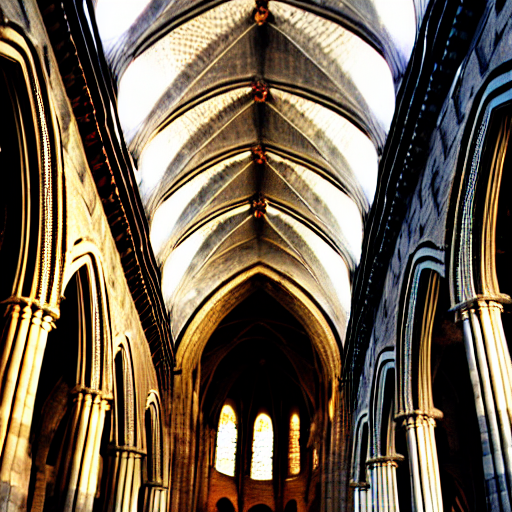

In [15]:
image = pipe(
    prompt="beautiful, high quality",
    ip_adapter_image_embeds=[pipe.encode_image(load_image(path), device="cuda", num_images_per_prompt=1)[0].unsqueeze(0)],
    negative_prompt="deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality",
    num_inference_steps=100,
    #generator=generator,
).images
image[0]

### Turning Images into CLIP

In [8]:
import os

sd15_ipadapter_baseline_embs = []
with torch.no_grad():
    for unq_img_path in tqdm(os.listdir("../eval_tests/uncond_images/")):
        path = "../eval_tests/uncond_images/" + unq_img_path
        pil_image = load_image(path)
        image_emb = pipe.encode_image(pil_image, device="cuda", num_images_per_prompt=1)[0].squeeze()
        sd15_ipadapter_baseline_embs.append(image_emb.cpu())

sd15_ipadapter_embs_tensor = torch.stack(sd15_ipadapter_baseline_embs)
torch.save(sd15_ipadapter_embs_tensor, "../eval_tests/uncond_images/sd15_embeddings.pt")

100%|██████████| 5000/5000 [02:41<00:00, 30.90it/s]


In [9]:
sd15_ipadapter_baseline_embs = []
with torch.no_grad():
    for unq_img_path in tqdm(os.listdir("../eval_tests/good_prompt_images/")):
        path = "../eval_tests/good_prompt_images/" + unq_img_path
        pil_image = load_image(path)
        image_emb = pipe.encode_image(pil_image, device="cuda", num_images_per_prompt=1)[0].squeeze()
        sd15_ipadapter_baseline_embs.append(image_emb.cpu())

sd15_ipadapter_embs_tensor = torch.stack(sd15_ipadapter_baseline_embs)
torch.save(sd15_ipadapter_embs_tensor, "../eval_tests/good_prompt_images/sd15_embeddings.pt")

100%|██████████| 5000/5000 [02:39<00:00, 31.37it/s]


In [ ]:
import os

sd15_ipadapter_baseline_embs = []
with torch.no_grad():
    for unq_img_path in tqdm(os.listdir("../eval_tests/uncond_images/")):
        path = "../eval_tests/uncond_images/" + unq_img_path
        pil_image = load_image(path)
        image_emb = pipe.encode_image(pil_image, device="cuda", num_images_per_prompt=1)[0].squeeze()
        sd15_ipadapter_baseline_embs.append(image_emb.cpu())

sd15_ipadapter_embs_tensor = torch.stack(sd15_ipadapter_baseline_embs)
torch.save(sd15_ipadapter_embs_tensor, "../eval_tests/uncond_images/sd15_embeddings.pt")

In [15]:
sd15_ipadapter_embs = []
with torch.no_grad():
    for unq_img_path in tqdm(ratings_df.imagePair.unique()):
        path = "../data/flickr/raw/40K/" + unq_img_path
        pil_image = load_image(path)
        image_emb = pipe.encode_image(pil_image, device="cuda", num_images_per_prompt=1)[0].squeeze()
        sd15_ipadapter_embs.append(image_emb.cpu())

sd15_ipadapter_embs_tensor = torch.stack(sd15_ipadapter_embs)
torch.save(sd15_ipadapter_embs_tensor, "../data/flickr/processed/ip-adapters/sd1.5/sd15_image_embeddings.pt")

100%|██████████| 40959/40959 [33:17<00:00, 20.51it/s]


### Image Embeddings SDXL - IP-Adapter

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from diffusers import AutoPipelineForText2Image
from diffusers import DiffusionPipeline, StableDiffusionXLPipeline
from diffusers.utils import load_image
import pandas as pd
from tqdm import tqdm
import torch

#### Necessary

In [9]:
base = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
).to("cuda")
base.load_ip_adapter("h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter_sdxl.bin")
refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
).to("cuda")

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


ip-adapter_sdxl.bin:   0%|          | 0.00/703M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.69G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/4.52G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
ratings_df = pd.read_csv("../data/flickr/processed/ratings.csv")

In [12]:
sdxl_ipadapter_embs = []
with torch.no_grad():
    for unq_img_path in tqdm(ratings_df.imagePair.unique()):
        path = "../data/flickr/raw/FLICKR-AES-001/40K/" + unq_img_path
        pil_image = load_image(path)
        #out = base.image_encoder(pil_image)
        #image_emb = out["image_embeds"][0]  # shape 1280
        #sdxl_ipadapter_embs.append(image_emb.cpu())
        image_emb = base.encode_image(pil_image, device="cuda", num_images_per_prompt=1)[0].squeeze()
        sdxl_ipadapter_embs.append(image_emb.cpu())

sdxl_ipadapter_embs_tensor = torch.stack(sdxl_ipadapter_embs)
torch.save(sdxl_ipadapter_embs_tensor, "../data/flickr/processed/embeddings/SDXL/sdxl_image_embeddings.pt")

100%|██████████| 40959/40959 [11:56<00:00, 57.14it/s]


In [14]:
sdxl_ipadapter_embs_tensor = torch.load("../data/flickr/processed/embeddings/SDXL/sdxl_image_embeddings.pt").to("cuda")

In [15]:
sdxl_ipadapter_embs_tensor.shape

torch.Size([40959, 1280])

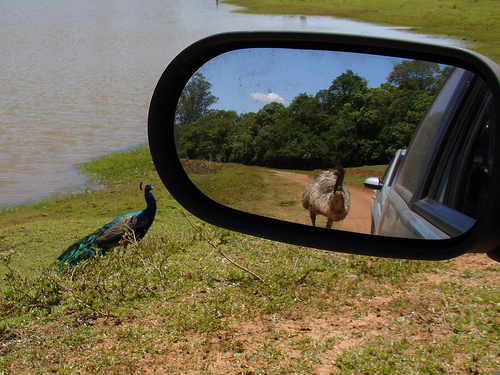

In [12]:
path = "../data/raw/FLICKR-AES-001/40K/" + ratings_df.imagePair.unique()[2]
load_image(path)

  0%|          | 0/100 [00:00<?, ?it/s]

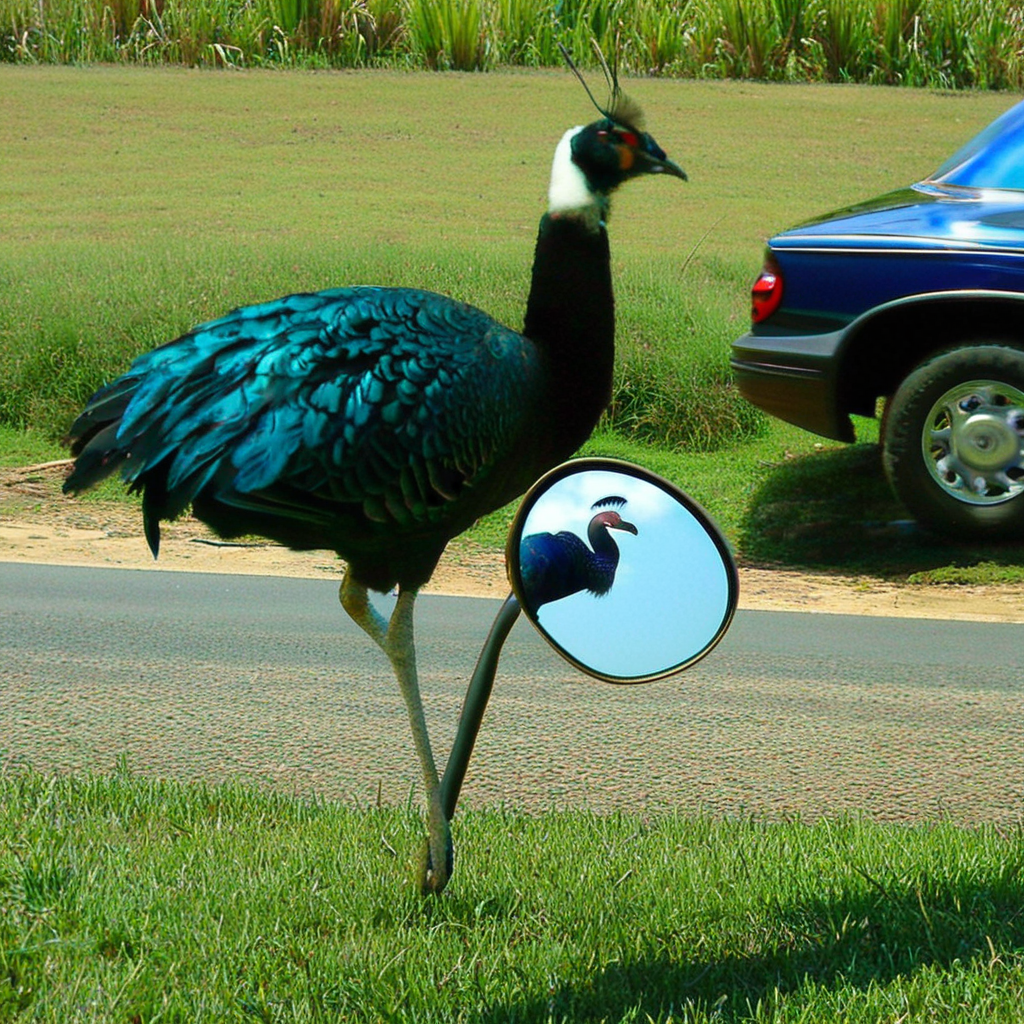

In [14]:
generator = torch.Generator(device="cpu").manual_seed(0)
images = base(
    prompt="",
    ip_adapter_image_embeds=[sdxl_ipadapter_embs_tensor[2].unsqueeze(0).unsqueeze(0)],
    #ip_adapter_image=load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/ip_adapter_diner.png"),
    negative_prompt="deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality",
    num_inference_steps=100,
    generator=generator,
).images
images[0]